In [3]:
import pandas as pd
from pathlib import Path

# import plotly.express as px
from matplotlib import pyplot as plt
import numpy as np

from collections import OrderedDict

COLUMN_NAMES = ['epoch', 'step', 'batch_loss', 'full_loss', 'batch_lmax', 'lmax', 'batch_sharpness', 'total_ghg', 'fisher_batch_eig', 'fisher_total_eig', 'batch_sharpness_static', 'gni', 'full_acc', 'param_dist']


In [ ]:
RESULTS_FOLDER = Path('/scratch/gpfs/andreyev/eoss/results')

# Load the sharpness data

In [8]:
paths = {
        'base': '''cifar10_mlp/20250130_1737_34_lr0.01000_b4
cifar10_mlp/20250130_1737_34_lr0.01000_b8
cifar10_mlp/20250130_1739_19_lr0.01000_b16''',
}

In [9]:
dataset_size = 8192
# dataset_size = 4096

In [10]:
current_paths = paths['base']

runs_list = OrderedDict()


if type(current_paths) == str: 
    current_paths = current_paths.strip().split('\n')


for run_path, i in zip(current_paths, range(len(current_paths))):
    entry = {}
    batch_size = int(run_path.split('_')[-1][1:])
    run_path = run_path.strip()
    file_path = RESULTS_FOLDER / run_path / 'results.txt'
    curr_df = pd.read_csv(file_path, skiprows=4, sep=',', header=None, names=COLUMN_NAMES, na_values=['nan'], 
                          skipinitialspace=True)
    


     
    # Get the learning rate
    lr_size = run_path.split('_')[-2][2:]
    batch_size = int(run_path.split('_')[-1][1:])
    key = i
    lr = float(lr_size)
    entry['df'] = curr_df
    entry['lr'] = lr
    entry['batch_size'] = batch_size

    runs_list[key] = entry

model_name = run_path.split('/')[0].split('_')[1:]

model_name = '_'.join(model_name)


# Do the plots

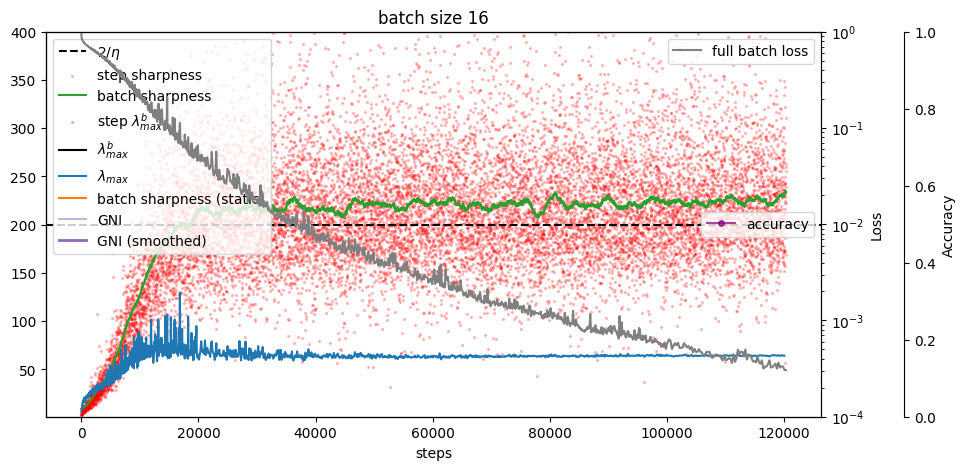

In [11]:


for i, k in enumerate(sorted(runs_list.keys())):
    run = runs_list[k]

    lr = run['lr']
    batch_size = run['batch_size']
    # label = run['label']
    df = run['df']

    fig, ax = plt.subplots(figsize=(10, 5))

    
    ax.axhline(y=2/lr, color='black', linestyle='--', label=r'2/$\eta$')
    
    
    ax.set_ylim(1, 2/lr*2)
    # ax.set_ylim(0, 20)

    
    ###### do the batch sharpness  #####

    ax.scatter(df['step'],
               df['batch_sharpness'], label='step sharpness', color='red', alpha=0.2, s=2)
    steps_in_epoch = dataset_size // batch_size
    average_over = steps_in_epoch * int(np.sqrt(batch_size))

    # Compute the average of 'batch_sharpness' every 100 steps (excluding NaN values)
    df['batch_sharpness_avg'] = (df['batch_sharpness']).rolling(window=average_over, min_periods=1, center=True).mean()

    # Plot the averaged 'batch_sharpness'
    ax.plot(df['step'], df['batch_sharpness_avg'], color='#2ca02c', label='batch sharpness', linewidth=1.5)


    ###### do the batch lambda max ####
    ax.scatter(df['step'],
               df['batch_lmax'], label=r'step $\lambda^b_{max}$', color='blue', alpha=0.2, s=2)
    steps_in_epoch = dataset_size // batch_size
    average_over = steps_in_epoch * int(np.sqrt(batch_size))
    # Compute the average of 'batch_sharpness' every 100 steps (excluding NaN values)
    df['batch_lmax_avg'] = (df['batch_lmax']).rolling(window=average_over, min_periods=1, center=False).mean()
    # Plot the averaged 'batch_sharpness'
    ax.plot(df['step'], df['batch_lmax_avg'], color='black', label=r'$\lambda^b_{max}$', linewidth=1.5)


    #### do the lambda max ####

    valid_data = df[['step', 'lmax']].dropna()

    ax.plot(valid_data['step'],
            valid_data['lmax'],
            label=r'$\lambda_{max}$',
            color='#1f77b4',
            linewidth=1.5)

    
    #### do the static batch sharpness ####

    valid_data = df[['step', 'batch_sharpness_static']].dropna()

    ax.plot(valid_data['step'],
                valid_data['batch_sharpness_static'],
                label='batch sharpness (static)',
                color='#ff7f0e',  # Changed color to orange
                linewidth=1.5)

    
    #### do the GNI ####

    valid_data = df[['step', 'gni']].dropna()

    ax.plot(valid_data['step'],
                    valid_data['gni'],
                    label='GNI',
                    color='#9467bd',  # Changed to purple
                    alpha=0.5,
                    linewidth=1.5)
    
    # Calculate smoothed GNI using rolling average
    valid_data_smooth = df[['step', 'gni']].dropna()
    valid_data_smooth['gni_smooth'] = valid_data_smooth['gni'].rolling(window=20, min_periods=1, center=True).mean()

    ax.plot(valid_data_smooth['step'],
        valid_data_smooth['gni_smooth'],
        label='GNI (smoothed)',
        color='#9467bd',  # Same purple but with transparency
        alpha=1,
        linewidth=2)



    #### add legends and co ###
    # ax.axvline(x=14848, color='purple', linestyle='--', label='LR increase spot')


    ax.legend(loc='upper left') 

    ax.set_title(f'batch size {batch_size}')
    ax.set_xlabel('steps')
    # ax.set_ylabel('sharpness')
    # ax.set_yscale('log')

    # ax.set_xlim(0, xlims[batch_size])
    # ax.set_xlim(0, 50_000)



    
    ##### add loss plot ###

    # Add accuracy plot along with loss
    # Add a second right-side y-axis for accuracy 
    ax3 = ax.twinx()
    # Offset the position of ax3 to the left
    ax3.spines['right'].set_position(('outward', 60))  # Move 60 points outward

    # Plot accuracy
    valid_acc = df[['step', 'full_acc']].dropna()
    ax3.plot(valid_acc['step'], valid_acc['full_acc'], 
             color='purple', label='accuracy',
             marker='o', markersize=4, linestyle='-', alpha=0.7)

    ax3.set_ylabel('Accuracy')
    ax3.set_ylim(0, 1)  # Accuracy is typically between 0 and 1
    ax3.legend(loc='center right')

    

    ax2 = ax.twinx()
    ax2.plot(df['step'], df['full_loss'].interpolate(), 
             color='gray', label='full batch loss',
             alpha=1)
    # Add batch loss rolling std with same window size as batch_sharpness_avg
    # df['batch_loss_std'] = df['batch_loss'].rolling(window=1000, min_periods=1, center=True).std()
    # ax2.fill_between(df['step'], 
    #                  df['total_loss'].interpolate() - df['batch_loss_std'],
    #                  df['total_loss'].interpolate() + df['batch_loss_std'],
    #                  color='gray', alpha=0.2)
    ax2.set_ylabel('Loss')
    ax2.set_yscale('log')
    ax2.set_ylim(1e-4, 1)
    ax2.legend(loc='upper right')


    
    
    
